In [2]:
import gym
import numpy as np
import random
from collections import namedtuple, defaultdict

from IPython.display import display, clear_output
from time import sleep

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import colors
%matplotlib inline

## Solving OpenAI's [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/)

**We control an agent on a ice field and need to figure out how to best get it past holes to the goal.**

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:

```
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
```

Putting the lake in a string in case I decide to plot it or something:

In [49]:
lake_4x4 = """SFFF
FHFH
FFFH
HFFG"""

The agent movements are:

In [48]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

Lets make the environment and take a look at it:

In [46]:
env = gym.make('FrozenLake-v0')
print(env.action_space, env.observation_space, env.reward_range)
env.render()

Discrete(4) Discrete(16) (0, 1)

SFFF
FHFH
FFFH
HFFG


So our agent can take 4 actions (left, down, right, up) and has 16 places to go to (or the state)m and starts in the top left corner, which is presumably state 0.

In [69]:
observation = env.reset()

direction = {0:"Left", 1: "Down", 2: "Right", 3: "Up"}

env.render()
sleep(0.3)

for action in [1,1,1]:
    observation, reward, done, info = env.step(action)
    clear_output(wait=True)
    env.render()
    print(f"moved {direction[action]}")
    print(observation, reward, done, info)
    sleep(0.3)

  (Down)
SFFF
FHFH
FFFH
HFFG
moved Down
5 0 True {'prob': 1.0}


Moving the agent randomly to see whats happening:

In [70]:
observation = env.reset()
done = False
while not done:
    observation, reward, done, info = env.step(env.action_space.sample())
    clear_output(wait=True)
    env.render()
    print(observation, reward, done, info)
    sleep(0.3)

  (Right)
SFFF
FHFH
FFFH
HFFG
5 0.0 True {'prob': 0.3333333333333333}


This agent is dumb - falls into a hole all the time! So we need a smarter solution, which is where markov decision processes (MDPs) and q tables come in.

- **MDP** fancy word to describe an environment
- **markov property**: screw the past, we only care about now. So we can discard any previous knowledge, sort of like how American elections work, and just decide on the future based on now.
- **markow rewards:** we use a reward function `R` and a discount factor `gamma` b/w 0 and 1 to assign a reward to each (state, action) pair.
- **Probability:** the `P` gives us the probability of a state
- **q tables:** for every state and action possible from that state we store a value for that (state, action) pair. Once the q-table is filled out it helps us decide the best course of action from any given (state, action) pair. So really, this is where the magic happens.

moving on the implementation, starting with qtables:


Q tables can be done as a class object, but since we have a simple environment I'm using a numpy arrary initialized with zeros to keep things simple.

For each observation or state we have 4 possible actions, and I'm going to store the Q value for each state/action pair in a 2d array.

First up, visualizing the qtable and the agent:

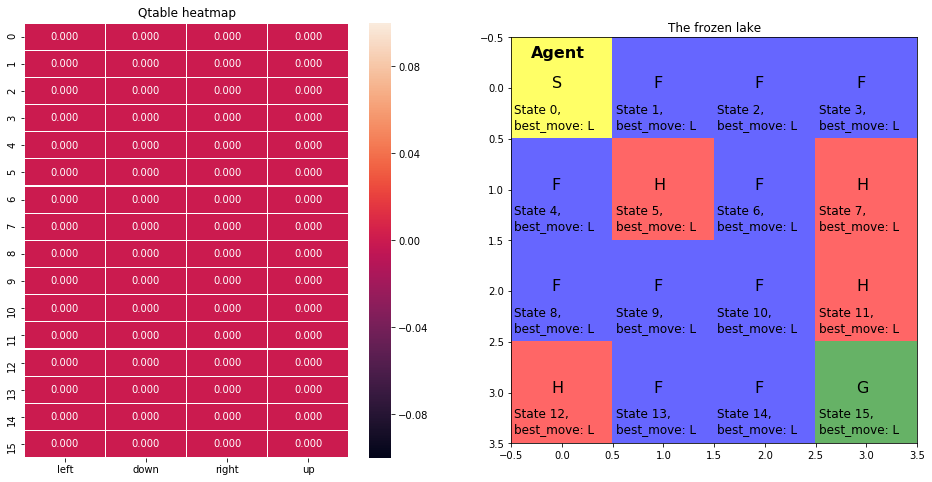

In [71]:
qtable = np.zeros((env.observation_space.n, env.action_space.n))

def viz(agent_state=0, lake=lake_4x4):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    
    # plot the qtable
    sns.heatmap(qtable, linewidth=0.2, ax=ax1, 
                annot=True, fmt=".3f", 
                xticklabels="left down right up".split())
    ax1.set_title("Qtable heatmap")
    clear_output(wait=True)
    
    # show the grid
    
    con = {"S": 0, "F":1, "H":2, "G":3}
    lake_letters = [[l[i] for i in range(4)] for l in lake.splitlines()]
    lake = [[con[l[i]] for i in range(4)] for l in lake.splitlines()]
    cmap = colors.ListedColormap(['yellow','blue','red','green'])
    
    ax2.set_title("The frozen lake")
    ax2.imshow(lake, alpha=0.6, cmap=cmap)

    #labelling grid
    for row_num, row in enumerate(lake_letters):
        for char_num, char in enumerate(row):
            state = row_num*4+char_num
            
            if state == agent_state:
                ax2.annotate("Agent", xy=(char_num-0.31, row_num-0.3), fontsize=16, weight="bold")
            
            ax2.annotate(char, xy=(char_num-0.1, row_num), fontsize=16)
            best_move = mv[np.argmax(qtable[state])]
            ax2.annotate(f"State {state}, \nbest_move: {best_move}", 
                         xy=(char_num-0.47, row_num+0.4), fontsize=12)
    
    plt.show()

viz()

We can access and update a (state,action) pair by doing `qtable[state,action]`

now moving on to the function to update the q table after our agent takes a move, I'm updating it using wikipedias definition: https://www.wikiwand.com/en/Q-learning

The parameters:

In [94]:
episodes = 150000
epsilon=0.8 # our max epsilon value, fix this so it increases slowly
alpha = 0.81 # the learning rate
gamma = 0.91 # the discount rate

now to do some learning:

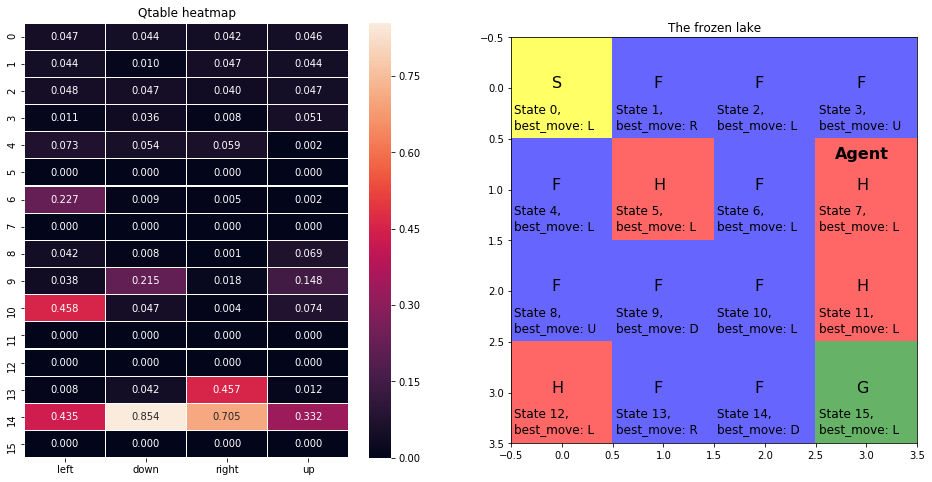

'reached goal 7044 times in 150000 episodes'

In [107]:
qtable = np.zeros((env.observation_space.n, env.action_space.n))

def learn_greedy(episodes=episodes, show=False):
    """moves agent, updates qtable"""
    
    rate = 10 / episodes  # the rate at which to increase epsilon
    reached_goal = 0
    
    for i in range(episodes):
        state = env.reset()  # reset for each episode
        done = False
        ep = epsilon - epsilon * 1/(1 + rate*i) # grow epsilon from zero to max
        
        while not done:
            if np.random.random() < ep:
                action = np.argmax(qtable[state])
            else:
                action = env.action_space.sample() # move in a random direction
            
            new_state, reward, done, info = env.step(action) # moved the agent
            
            # update q table
            qtable[state, action] += alpha * (reward + gamma * np.max(qtable[new_state]) 
                                  - qtable[state, action])
            state = new_state
        if state == 15:
            reached_goal += 1
            
        if i % 1000 == 0:
            viz(state)
    env.close()
    return f"reached goal {reached_goal} times in {episodes} episodes"        
    
learn_greedy()

In [108]:
def play_greedy(episodes=1, epsilon=1, show=False):
    for i in range(episodes):
        state = env.reset()  # reset for each episode
        done = False
        reached_goal = 0
        
        while not done:
            if np.random.random() < epsilon:
                action = np.argmax(qtable[state])
            else:
                action = env.action_space.sample() # move in a random direction
            state, reward, done, info = env.step(action) # moved the agent
            if show: viz(state)
        if state == 15:
            reached_goal += 1    
    env.close()
    return f"reached goal {reached_goal} times from {episodes} episodes played"
    
play_greedy(episodes=2000, show=False)

'reached goal 0 times from 2000 episodes played'

# growing epsilon

using this to grow epsilon, look at other methods:

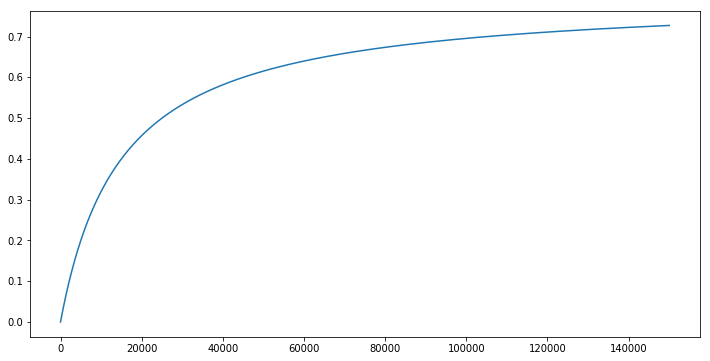

In [106]:
ep = 0
eps = []
plt.figure(figsize=(12,6))
rate = 10 / episodes
for i in range(1,episodes):
    eps.append(epsilon - epsilon * 1/(1 + rate*i))
plt.plot(eps);

In [8]:
1/episodes

5e-05